In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
import torchvision
from torchvision import utils, datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

device:  cuda


In [4]:
# Datasets
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.CIFAR100(
    root="./datasets", train=True, download=True, transform=transform)
test_data = datasets.CIFAR100(
    root="./datasets", train=False, download=True, transform=transform)
print(f'Train: {len(train_data)}, Test: {len(test_data)}')

Files already downloaded and verified
Files already downloaded and verified
Train: 50000, Test: 10000


In [5]:
batch_size = 200
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


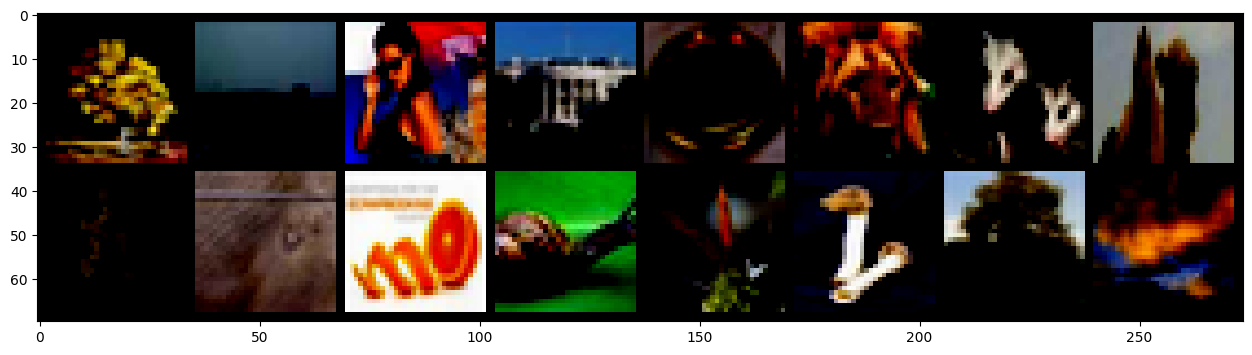

In [6]:
def imshow(img):
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img)
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


figure = plt.figure(figsize=(20, 4))
example_mini_batch_img, example_mini_batch_label = next(iter(train_dataloader))
imshow_grid(example_mini_batch_img[0:16, :, :])

In [44]:
a = next(iter(train_dataloader))
b = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


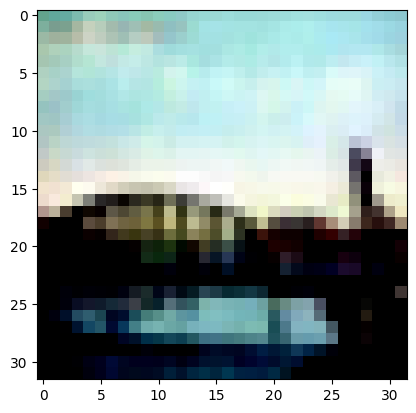

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


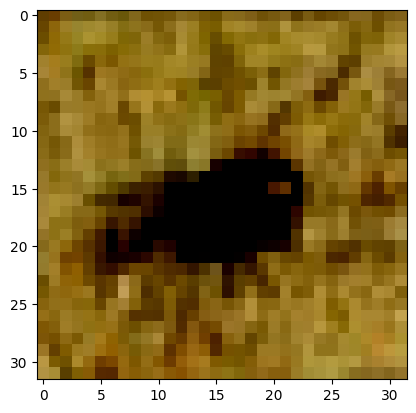

In [45]:
img = a[0]
img2 = b[0]
imshow(img[0].permute(1, 2, 0).unsqueeze(0))
imshow(img2[0].permute(1, 2, 0).unsqueeze(0))

In [50]:
import pytorch-fid-wrapper

SyntaxError: invalid syntax (1237681058.py, line 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


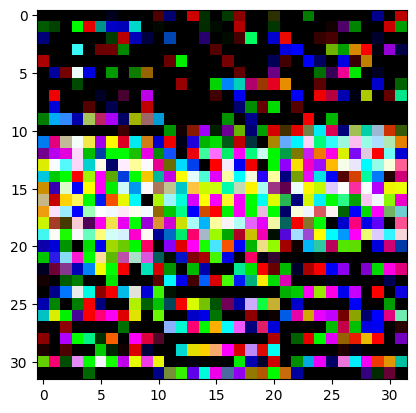

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


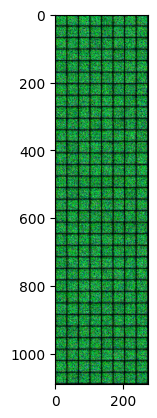

In [79]:
# dataloader에서 사용할 쓰레드 수
workers = 1

# 배치 크기
batch_size = 256

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 32

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 100

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1


def sample_z(batch_size=1, nz=100):
    return torch.randn(batch_size, nz, 1, 1, device=device)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

generator = Generator(ngpu).to(device)
z = sample_z()
img_fake = generator(z).view(32, 32, 3)
imshow(img_fake.squeeze().cpu().detach())

z = sample_z(batch_size)
img_fake= generator(z)
imshow_grid(img_fake)

In [82]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64`` 입니다
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

discriminator = Discriminator(ngpu).to(device)
print(generator(z).shape)
print(discriminator(generator(z)).shape)
print(discriminator(generator(z)[0:5]).transpose(0, 1))

torch.Size([256, 3, 32, 32])
torch.Size([256, 1, 1, 1])
tensor([[[[0.4963]],

         [[0.5760]],

         [[0.4841]],

         [[0.4932]],

         [[0.2969]]]], device='cuda:0', grad_fn=<TransposeBackward0>)


In [95]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    loop = tqdm(train_dataloader, desc=f'[{epoch+1}/{num_epochs}]')
    for i, data in enumerate(loop):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        discriminator.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = discriminator(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = generator(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = discriminator(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = discriminator(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        loop.set_postfix_str('\tLoss_D: %.4f, Loss_G: %.4f\tD(x): %.4f, D(G(z)): %.4f / %.4f' % (errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # if i % 50 == 0:
        #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #           % (epoch, num_epochs, i, len(train_dataloader),
        #              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


[1/100]:   0%|          | 0/250 [00:00<?, ?it/s]

[100/100]: 100%|██████████| 250/250 [00:21<00:00, 11.48it/s, 	Loss_D: 0.1422, Loss_G: 5.4005	D(x): 0.9760, D(G(z)): 0.1027 / 0.0090] 


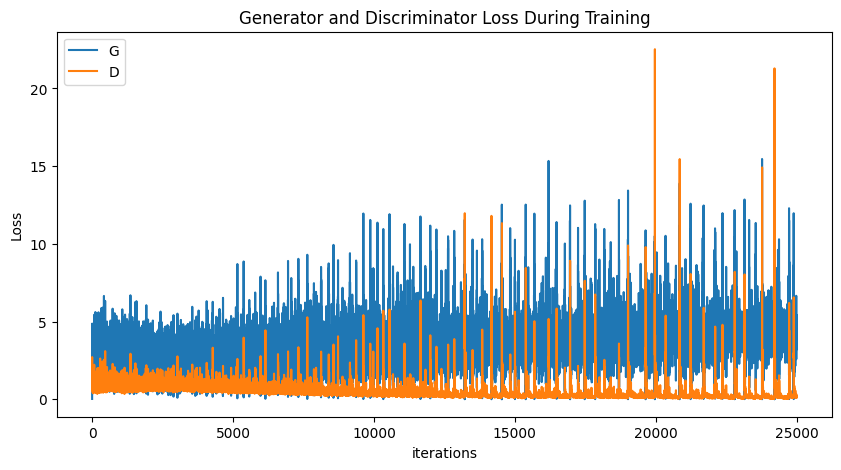

In [96]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

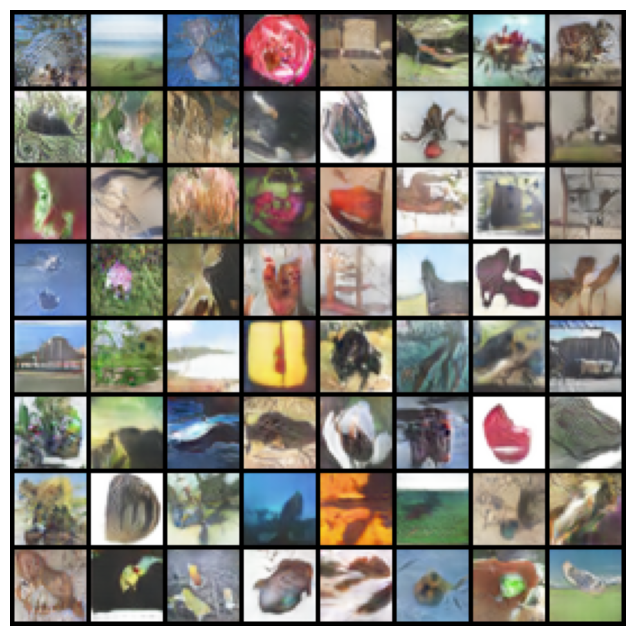

In [98]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())